## Imports

In [1]:
import numpy as np

import matplotlib.pyplot as plt

plt.rcParams['text.usetex'] = True

import os
import sys

sys.path.append(os.path.abspath('..'))

import torch
from src.models.GaussianProcess import GaussianProcessRegressor, SinusoidalKernel, RBFKernel

## Data Generation Function

In [2]:
amplitude = 1
period = np.pi/2

def f(x):
    return amplitude * torch.sin(period * x)


## Creating Gaussian Process

In [3]:
lower_in = 0
upper_in = 10
num_train = 40
x_train = torch.cat([torch.linspace(lower_in, 4, num_train), torch.linspace(6, upper_in, num_train)]).unsqueeze(1).to(torch.device('cuda')).to(torch.float64)
y_train = f(x_train).to(torch.device('cuda')).to(torch.float64)

kernel_exp = RBFKernel(length_scale=1.0, amplitude=1.0).to(torch.device('cuda'))

gp_exp = GaussianProcessRegressor(kernel_exp, noise=0.0, max_iter=2_000, batch_size=num_train, lr=0.01, delta=1e-5)
gp_exp = gp_exp.fit(x_train, y_train)

Iteration      0, Loss:       5.80
Iteration     50, Loss:      -6.77
Iteration    100, Loss:      -6.44
Iteration    150, Loss:     -10.17
Iteration    200, Loss:      -8.82
Iteration    250, Loss:      -7.80
Iteration    300, Loss:      -7.74
Iteration    350, Loss:      -8.51
Iteration    400, Loss:      -8.89
Iteration    450, Loss:      -8.25
Iteration    500, Loss:      -7.11
Iteration    550, Loss:      -7.84
Iteration    600, Loss:      -6.58
Iteration    650, Loss:      -9.76
Iteration    700, Loss:      -6.40
Iteration    750, Loss:      -8.50
Iteration    800, Loss:      -7.66
Iteration    850, Loss:      -8.16
Iteration    900, Loss:      -9.17
Iteration    950, Loss:      -5.50
Iteration   1000, Loss:      -6.73
Iteration   1050, Loss:      -7.24
Iteration   1100, Loss:      -8.02
Iteration   1150, Loss:      -6.84
Iteration   1200, Loss:      -6.08
Iteration   1250, Loss:     -11.39
Iteration   1300, Loss:      -9.29
Iteration   1350, Loss:     -10.37
Iteration   1400, Lo

## Plotting GP Samples

torch.Size([30, 100])


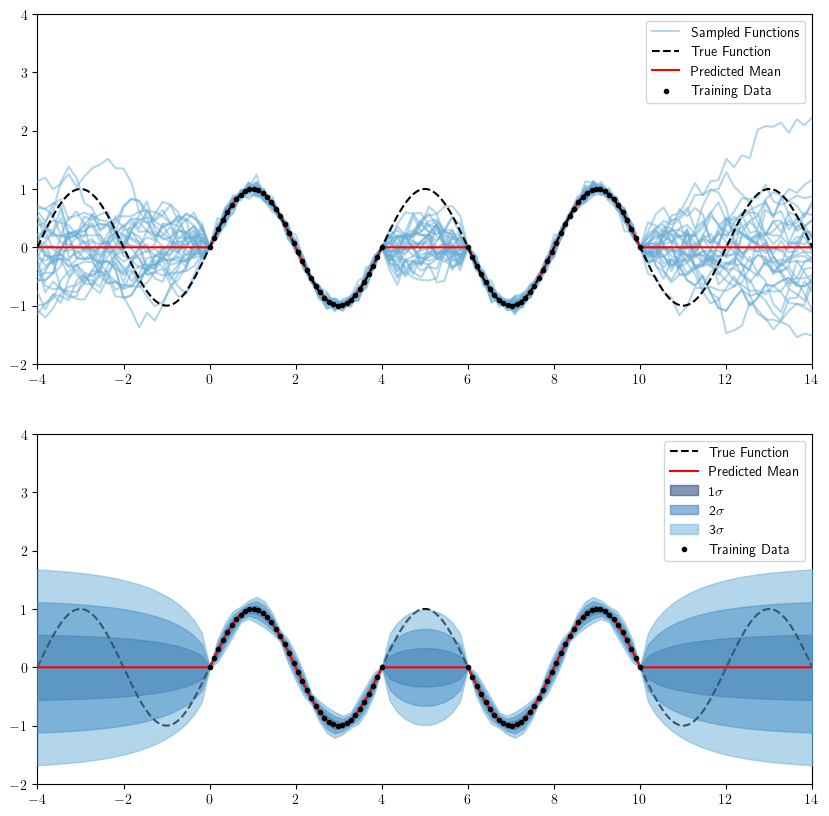

In [4]:
def to_numpy(tensor):
    return tensor.cpu().detach().numpy()


cmap = plt.get_cmap('Blues')
colors = list(reversed([cmap(i) for i in np.linspace(0.5, 1, 3)]))
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(10, 10))

x_test = torch.linspace(-4, 14, 100, device=torch.device('cuda')).unsqueeze(1)

y_pred, y_std = gp_exp.predict(x_test, return_std=True)
y_samples = gp_exp.predict(x_test, num_samples=30)

print(y_samples.shape)

for i, sample in enumerate(y_samples):
    ax0.plot(to_numpy(x_test), to_numpy(sample), c=colors[2], alpha=0.5, zorder=i*5)

ax0.plot(to_numpy(x_test), to_numpy(y_samples[-1]), c=colors[2], alpha=0.5, label='Sampled Functions')

ax0.plot(np.linspace(lower_in-4, upper_in+4, 1000), f(torch.linspace(lower_in-4, upper_in+4, 1000)), c='black', linestyle="dashed", label='True Function', zorder=175)
ax0.plot(to_numpy(x_test), to_numpy(y_pred), 'r', label='Predicted Mean', zorder=160)
ax1.plot(np.linspace(lower_in-4, upper_in+4, 1000), f(torch.linspace(lower_in-4, upper_in+4, 1000)), c='black', linestyle="dashed", label='True Function', zorder=15)
ax1.plot(to_numpy(x_test), to_numpy(y_pred), 'r', label='Predicted Mean', zorder=20)




for i, color in zip([1,2,3], colors):
    upper = y_pred.squeeze() + i * y_std
    lower = y_pred.squeeze() - i * y_std

    ax1.fill_between(to_numpy(x_test).squeeze(), to_numpy(upper), to_numpy(lower), alpha=0.5, color=color, label= f"{i}" + r'$\sigma$', zorder=i*5)

ax0.scatter(x_train.cpu().numpy(), y_train.cpu().numpy(), c='black', marker='.', label='Training Data', zorder=200)
ax1.scatter(x_train.cpu().numpy(), y_train.cpu().numpy(), c='black', marker='.', label='Training Data', zorder=25)

ax0.set_xlim(-4, 14)
ax0.set_ylim(-2, 4)
ax1.set_xlim(-4, 14)
ax1.set_ylim(-2, 4)

ax0.legend()
ax1.legend()

plt.show()